<hr style="height:2px;border:none"/>
<img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">

<center>
    <h1> INF495 - Modelamiento Computacional Aplicado </h1>
    <h1> Project</h1>
    <h1> Modeling Fungi</h1>
    <h3>Jorge Sanhueza jorge.sanhuezac@sansano.usm.cl</h3>
</center>
<br>
<br>
<hr style="height:2px;border:none"/>


# Context

The project is based on the problem A of The Mathematical Contest in Modeling (MCM) 2021 
https://www.mathmodels.org/Problems/2021/MCM-A/2021_MCM_Problem_A.pdf>




The carbon cycle describes the process of the exchange of carbon throughout the geochemical
cycle of the Earth, and is a vital component for life on the planet.
Part of the carbon cycle includes the decomposition of compounds, allowing carbon to be renewed and used in other forms.
One key
component of this part of the process is the decomposition of plant material and woody fibers.

**Fungi** acts as a key agent in the decomposition of **wooden fibers and ground litter**

Different **fungi traits** affect in the **decomposition rate** of this fibers and ground litter.

For this MCM Problem you should focus on just two traits of a fungus:
 - The **growth rate** of the fungus
 - The fungus **tolerance to moisture**.
 
In particular, the slow growing strains of fungi tend to be better able to survive and grow in the presence of environmental changes with respect to moisture and temperature, while the faster growing strains tend to be less robust to the same changes.

The goal is to model the decomposition of woody fibers in a given patch of land, and do so in the presence of multiple types of fungi breaking down woody fibers in the same area.

As you explore the relationship of the two traits of interest, growth rate and moisture tolerance,
with the rate of decomposition, several questions may arise to include:

Using these two traits
- How do the different fungi **interact** and decompose ground litter in a fixed patch of land in different environments?
- Within these different environments, how will the **decomposition be impacted overtime** as conditions vary?
- How do environmental changes and the variation in environmental change impact the **long-term dynamics** with respect to decomposition, as well as competition between fungi in a given environment?

The estimation for the decomposition rates, given the growth rate, is shown
in Figure 1. The estimation of the decomposition rates, given the relative moisture tolerance, is
shown in Figure 2.


<img src="./figures/figures.png" style="width:70%">

# Agent-based Model 

# Enviroment

Patch of land of size nxm that holds Fungi and fibers. The humidity of the patch are separated by sections of different constant humidity.  

# Agents

Two types of fungi, slow growing strains of fungi (**S-Fungi**) and faster growing strains of fungi (**F-Fungi**).

Wood fibers and dead plant material (**Fibers**).

## S-Fungi
    - Decompose fibers slower
    - Withstands high humidity section
    - Grows slower than F-Fungi
    - When there is no fibers the fungi dies (lenght decreases?)
## F-Fungi
    - Decompose fibers faster
    - Cant Withstand high humidity section
    - Grows faster than S-Fungi
    - When there is no fibers the fungi dies (lenght decreases?)



In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp   
import seaborn as sns 
from matplotlib.colors import ListedColormap

from IPython.display import clear_output

In [68]:
SLOWFUNGI=1
FASTFUNGI=2
WOODFIBER=3
class World:
    def __init__(self,n,m,n_sfungi,n_ffungi,prob_fiber,prob_sfungi,prob_ffungi,resistance_sfungi,resistance_ffungi,sun_intensity):
        
        self.n = n
        self.m = m
        self.prob_fiber = prob_fiber
        self.prob_sfungi = prob_sfungi
        self.prob_ffungi = prob_ffungi
        self.resistance_sfungi= resistance_sfungi
        self.resistance_ffungi= resistance_ffungi
        self.sun_intensity = sun_intensity 

        self.land = np.zeros((n,n))

        
        self.populate_fibers = np.vectorize(self.scalar_populate_fibers)
        self.mapping = np.vectorize(self.scalar_mapping)

        self.sfungis = []
        for sfungi in range(n_sfungi):
            x,y = (np.random.randint(n),np.random.randint(n))
            while self.land[x,y] != 0:
                x,y = (np.random.randint(n),np.random.randint(n))
            self.sfungis.append((x,y))
            self.land[x,y] = SLOWFUNGI


        self.ffungis = []
        for ffungi in range(n_ffungi):
            x,y = (np.random.randint(n),np.random.randint(n))
            while self.land[x,y] != 0:
                x,y = (np.random.randint(n),np.random.randint(n))
            self.ffungis.append((x,y))
            self.land[x,y] = FASTFUNGI

        self.fibers()
        self.humidity = np.random.rand(n,m)
        self.sun = 0




    def fibers(self):
        self.land = self.populate_fibers(self.land)
    def scalar_populate_fibers(self,x):
                if x==0 and np.random.choice([True,False],p=[self.prob_fiber,1-self.prob_fiber]) :
                    return WOODFIBER
                else:
                    return x
    def scalar_mapping(self,x):
        if x==1:
            return 's'
        elif x==2:
            return 'f'
        elif x==3:
            return 'w'
        else:
            return ''

    def plot_world(self,annotate):
        cmapmine = ListedColormap(['w',"b",'g',"brown"], N=4)
        
        if annotate:
            ax = sns.heatmap(self.land, vmin=0,vmax=3,cmap=cmapmine,annot=self.mapping(self.land),fmt=' ')
        else:
            ax = sns.heatmap(self.land,cmap=cmapmine, vmin=0,vmax=3,xticklabels=False, yticklabels=False)
            ax.tick_params(left=False, bottom=False) 
        plt.show()
        plt.pause(0.01)
        clear_output(wait=True)

    def grow_helper(self,pos):
        i,j = pos
        adjacent_indices = []
        if i > 0 and self.land[i-1,j]==WOODFIBER :
            adjacent_indices.append((i-1,j))

        if i+1 < self.m and self.land[i+1,j]==WOODFIBER:
            adjacent_indices.append((i+1,j))

        if j > 0 and self.land[i,j-1]==WOODFIBER:
            adjacent_indices.append((i,j-1))

        if j+1 < self.n and self.land[i,j+1]==WOODFIBER:
            adjacent_indices.append((i,j+1))
        return adjacent_indices
    def grow(self):
        aux_ffungi = []
        for ffungi in self.ffungis:
            available = self.grow_helper(ffungi)
            if available:
                x,y = available[ np.random.choice(len(available))]
                if np.random.rand()<self.prob_ffungi:
                    self.land[x,y] = FASTFUNGI
                    aux_ffungi.append((x,y))
        self.ffungis = self.ffungis+aux_ffungi
        
        aux_sfungi = []
        for sfungi in self.sfungis:
            available = self.grow_helper(sfungi)
            if available:
                x,y = available[ np.random.choice(len(available))]
                if np.random.rand()<self.prob_sfungi:
                    self.land[x,y] = SLOWFUNGI
                    aux_sfungi.append((x,y))
        self.sfungis = self.sfungis+aux_sfungi

    def die(self):
        aux_ffungi = []
        for ffungi in self.ffungis:
            x,y = ffungi
            if y == self.sun:
                if self.humidity[x,y]-self.sun_intensity > self.resistance_ffungi:
                    aux_ffungi.append((x,y))
                else:
                    self.land[x,y] = 0
            else:
                if self.humidity[x,y] > self.resistance_ffungi:
                    aux_ffungi.append((x,y))
                else:
                    self.land[x,y] = 0

        self.ffungis = aux_ffungi

        aux_sfungi = []
        for sfungi in self.sfungis:

            x,y = sfungi
            if y == self.sun:
                if self.humidity[x,y]-self.sun_intensity > self.resistance_sfungi:
                    aux_sfungi.append((x,y))
                else:
                    self.land[x,y] = 0
            else:
                if self.humidity[x,y] > self.resistance_sfungi:
                    aux_sfungi.append((x,y))
                else:
                    self.land[x,y] = 0
        self.sfungis = aux_sfungi
        self.sun = (self.sun+1)%self.m

    def poblations(self):
        unique, counts = np.unique(self.land, return_counts=True)
        return dict(zip(unique, counts))
        


In [ ]:
def sim(n=50,m=50,n_sfungi=600,n_ffungi=600,prob_fiber=.3,prob_sfungi=0.3,prob_ffungi=0.4,resistance_sfungi=0.4,resistance_ffungi=0.3,sun_intensity=0.2,timelimit=200):
    try:
        annotation=False
        world = World(n,m,n_sfungi,n_ffungi,prob_fiber,prob_sfungi,prob_ffungi,resistance_sfungi,resistance_ffungi,sun_intensity)
        times = []
        sfungi_poblation = []
        ffungi_poblation = []
        woodfiber_poblation = []
        t=0
        timelimit = timelimit

        world.plot_world(annotation)
        poblations=world.poblations()
        sfungi_poblation.append(poblations[SLOWFUNGI])
        ffungi_poblation.append(poblations[FASTFUNGI])
        woodfiber_poblation.append(poblations[WOODFIBER])
        times.append(t)
        while(t<timelimit):
            world.grow()
            world.fibers()
            world.die()
            poblations=world.poblations()
            sfungi_poblation.append(poblations[SLOWFUNGI])
            ffungi_poblation.append(poblations[FASTFUNGI])
            woodfiber_poblation.append(poblations[WOODFIBER])
            world.plot_world(annotation)

            times.append(t)
            t+=1
        world.plot_world(annotation)
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(t),sfungi_poblation[:t],label="sfungi")
        plt.plot(np.arange(t),ffungi_poblation[:t],label="ffungi")
        plt.plot(np.arange(t),woodfiber_poblation[:t],label="woodfiber")
        plt.legend()
        plt.show()
        print("Poblaciones Finales")
        poblations=world.poblations()
        print(f"SLOWFUNGI {poblations[SLOWFUNGI]}")
        print(f"FASTFUNGI {poblations[FASTFUNGI]}")
        print(f"WOODFIBER {poblations[WOODFIBER]}")
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(t),sfungi_poblation[:t],label="sfungi")
        plt.plot(np.arange(t),ffungi_poblation[:t],label="ffungi")
        plt.plot(np.arange(t),woodfiber_poblation[:t],label="woodfiber")
        plt.legend()
        plt.show()
        print("Poblaciones Finales")
        poblations=world.poblations()
        print(f"SLOWFUNGI {poblations[SLOWFUNGI]}")
        print(f"FASTFUNGI {poblations[FASTFUNGI]}")
        print(f"WOODFIBER {poblations[WOODFIBER]}")


## land= 50x50, n_sfungi=600, n_ffungi=600

KeyboardInterrupt


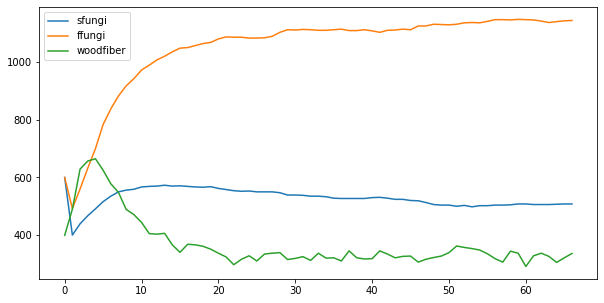

Poblaciones Finales
SLOWFUNGI 507
FASTFUNGI 1148
WOODFIBER 303


In [71]:
np.random.seed(201704575)
sim(n_sfungi=600, n_ffungi=600)

## land= 50x50, n_sfungi=300, n_ffungi=700

KeyboardInterrupt


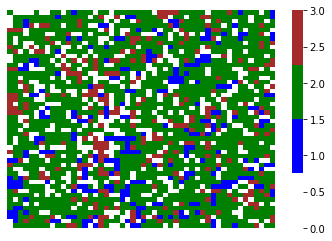

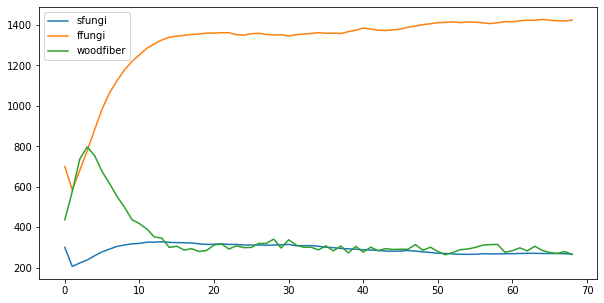

Poblaciones Finales
SLOWFUNGI 264
FASTFUNGI 1423
WOODFIBER 295


In [73]:
np.random.seed(201704575)
sim(n_sfungi=300, n_ffungi=700)

## land= 50x50, n_sfungi=700, n_ffungi=300

KeyboardInterrupt


<Figure size 432x288 with 0 Axes>

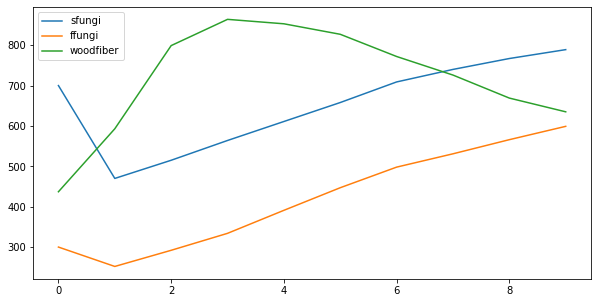

Poblaciones Finales
SLOWFUNGI 827
FASTFUNGI 641
WOODFIBER 531


In [74]:
np.random.seed(201704575)
sim(n_sfungi=700, n_ffungi=300)

In [ ]:

def f_competition(t,y,a1,a2,a3,a4,a5,cte,b):
    w = y[0]
    s = y[1]
    f = y[2]
    if w>200:
        w=200
    wp = cte  - a1*w -a2*w
    sp = a1*w-b*f -a3*s
    fp = a2*w-b*s -a4*f
    return np.array([wp,sp,fp])

a1 = .5
a3 = .1
a2 = .2
a4 = .2
cte = 20
b=0.2

y0 = np.array([100,20,30])
T = 100
# time where we want your solution
t = np.linspace(0, T, 100)
sol = solve_ivp(f_competition,[0,T], y0, t_eval=t, args=(a1,a2,a3,a4,a5,cte,b))

w_output = sol.y[0]
s_output = sol.y[1]
f_output = sol.y[2]
plt.figure()
plt.plot(t,w_output,label="fibers")
plt.plot(t,f_output,label="ffungi")
plt.plot(t,s_output,label="sfungi")
plt.legend()
plt.show()


In [ ]:

def f_competition(t,y,a1,a2,a3,a4,a5,cte,b):
    w = y[0]
    s = y[1]
    f = y[2]
    wp = cte  - a1*w -a2*w
    sp = a1*w-b*f -a3*s
    fp = a2*w-b*s -a4*f
    # if wp>100:
    #     wp=100
    # if wp<0:
    #     wp=0
    # if sp<0:
    #     sp=0
    # if fp<0:
    #     fp=0
    return np.array([wp,sp,fp])

a1 = .4
a3 = .1


a2 = .4
a4 = .2

cte = 20
b=0.2

y0 = np.array([5,20,30])
T = 100
# time where we want your solution
t = np.linspace(0, T, 100)
sol = solve_ivp(f_competition,[0,T], y0, t_eval=t, args=(a1,a2,a3,a4,a5,cte,b))

w_output = sol.y[0]
s_output = sol.y[1]
f_output = sol.y[2]
plt.figure()
plt.plot(t,w_output,label="fibers")
plt.plot(t,f_output,label="ffungi")
plt.plot(t,s_output,label="sfungi")
plt.legend()
plt.show()


In [ ]:
def f_competition(t,y,r1,r2,k1,k2,alpha12,alpha21):
    n1 = y[0]
    n2 = y[1]
    n1p=r1*n1*(k1-n1-alpha12*n2)/k1
    n2p=r2*n2*(k2-n2-alpha21*n1)/k2

    return np.array([n1p,n2p])
r1=1.14
r2=0.78
alpha21=0.33
alpha12=0.85
k1=44.3
k2=35.3

y0=np.array([30,30])
T = 15
# time where we want your solution
t = np.linspace(0, T, 100)
sol = solve_ivp(f_competition,[0,T], y0, t_eval=t, args=(r1,r2,k1,k2,alpha12,alpha21))

n1_output = sol.y[0]
n2_output = sol.y[1]

plt.figure()
plt.plot(t,n1_output,label="sfungi")
plt.plot(t,n2_output,label="sfungi")
plt.legend()
plt.show()
n1_output